In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns



In [2]:
data = pd.read_parquet('../data/cleanedData/allData.parquet')

data['hour'] = data['measurementDate'].dt.hour
data['minute'] = data['measurementDate'].dt.minute
data['day_of_week'] = data['measurementDate'].dt.dayofweek
data['month'] = data['measurementDate'].dt.month

data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

data = data.drop(columns=['measurementDate', 'hour', 'month'])

In [3]:
# amount_of_shift=1
# data['lag_1'] = data['oxygenValue'].shift(amount_of_shift)
# data['lag_2'] = data['oxygenValue'].shift(amount_of_shift+1)
# data['lag_3'] = data['oxygenValue'].shift(amount_of_shift+2)

# data['rolling_mean_3'] = data['oxygenValue'].rolling(window=3).mean()
# data['rolling_std_3'] = data['oxygenValue'].rolling(window=3).std()

# data = data.dropna()

In [4]:
lag_features = ['nitrateValue', 'phosphateValue', 'ammoniumValue', 'waterFlowPerMinute', 'precipitation']
n_lags = 2  # Number of lag periods

# Creating lag features
for feature in lag_features:
    for lag in range(1, n_lags + 1):
        data[f'{feature}_lag_{lag}'] = data[feature].shift(lag)

# Drop rows with NaN values created by the lagging process
data = data.dropna()

# Define features and target again after creating lagged features
features = [col for col in data.columns if col != 'oxygenValue']
target= 'oxygenValue'
X = data[features]
y = data[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [5]:
# fig, axes = plt.subplots(2, 3, figsize=(10, 5))
# features = ['nitrateValue', 'phosphateValue', 'ammoniumValue', 'waterFlowPerMinute', 'precipitation']

# for i, feature in enumerate(features):
#     sns.histplot(data[feature], ax=axes[i // 3, i % 3], kde=True)
#     axes[i // 3, i % 3].set_title(feature)

# plt.tight_layout()
# plt.show()

In [6]:
# for feature in ['nitrateValue', 'phosphateValue', 'ammoniumValue', 'waterFlowPerMinute', 'precipitation']:
#     data[feature] = np.log(data[feature] + 1e-9)

# fig, axes = plt.subplots(2, 3, figsize=(10, 5))
# features = ['nitrateValue', 'phosphateValue', 'ammoniumValue', 'waterFlowPerMinute', 'precipitation']

# for i, feature in enumerate(features):
#     sns.histplot(data[feature], ax=axes[i // 3, i % 3], kde=True)
#     axes[i // 3, i % 3].set_title(feature)

# plt.tight_layout()
# plt.show()

In [7]:
cpu_cores = 10
memory_as_cache=12000

def scale_data_chunk(data_chunk, scaler):
    return scaler.transform(data_chunk)

def fit_svr_chunk(X_chunk, y_chunk):
    model = SVR(kernel='rbf', cache_size=memory_as_cache, gamma=0.001, epsilon=0.01)
    model.fit(X_chunk, y_chunk)
    return model

def predict_svr_chunk(data_chunk, models):
    predictions = np.mean([model.predict(data_chunk) for model in models], axis=0)
    return predictions

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)


X_train_chunks = np.array_split(X_train_scaled, cpu_cores)
y_train_chunks = np.array_split(y_train, cpu_cores)

svr_models = Parallel(n_jobs=cpu_cores)(delayed(fit_svr_chunk)(X_chunk, y_chunk) for X_chunk, y_chunk in zip(X_train_chunks, y_train_chunks))

X_test_scaled = scaler.transform(X_test)

X_test_chunks = np.array_split(X_test_scaled, cpu_cores)

y_pred_chunks = Parallel(n_jobs=cpu_cores)(delayed(predict_svr_chunk)(chunk, svr_models) for chunk in X_test_chunks)

y_pred = np.concatenate(y_pred_chunks)


rmse = root_mean_squared_error(y_test, y_pred)  
mse = mean_squared_error(y_test, y_pred)  
mae = mean_absolute_error(y_test, y_pred)  
r2 = r2_score(y_test, y_pred)  

print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')


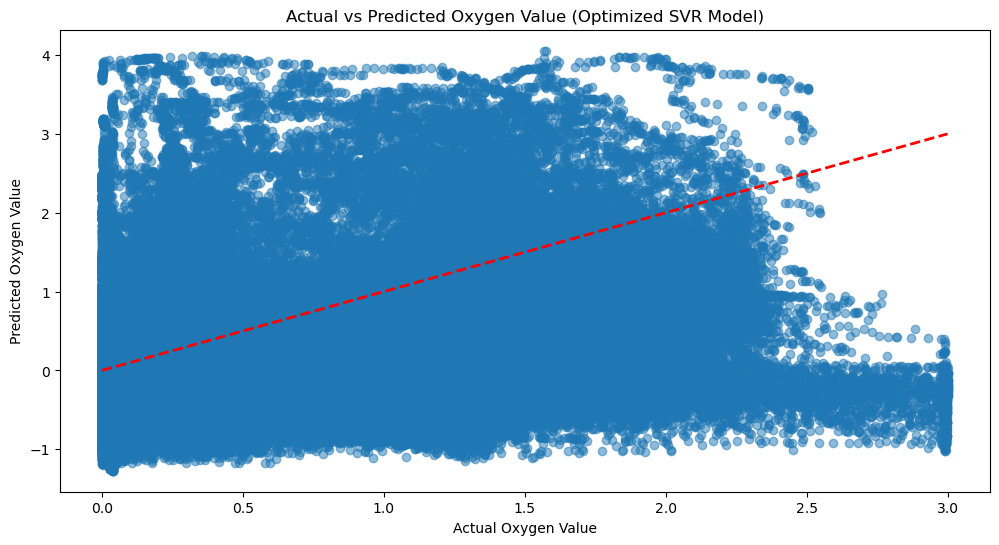

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual Oxygen Value')
plt.ylabel('Predicted Oxygen Value')
plt.title('Actual vs Predicted Oxygen Value (Optimized SVR Model)')
plt.show()
